In [1]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import cmath
import math
from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel
from statannotations.Annotator import Annotator
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from concat_pickles import get_outputs,get_outputs_wTraces,print_df
from metrics import get_R2

fig_folder = '/Users/kendranoneman/Figures/neural-decoding'

data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)
sess_size = len(out_times)

#cols = ['forestgreen','limegreen','deepskyblue','royalblue','mediumpurple','mediumvioletred','crimson','darkorange']
#           wf           wc                 xgb          svr          dnn            rnn             gru          lstm

cols = ['#317c32','#20a693','#358eb9','#3127d7','#a624d7','#d51f89','#dc6d3f','#f1c232']
cols = [mcolors.to_rgb(col) for col in cols]

grays = ['#c1d7c1','#bce4de','#c2ddea','#c1bef3','#e4bdf3','#f2bbdb','#f4d3c5','#faecc1']
grays = [mcolors.to_rgb(col) for col in grays]

pal_cols = ['#B3AA00','#74B300','#00B315','#00B377','#008CB3','#002DB3','#3C00B3','#8C00B3']
pals = [sns.light_palette(col, as_cmap=True) for col in cols]

# Display the RGB values for plotting
#rgb_array = np.array(rgb_cols)

#reds =[(1.0, 0.0, 0.0), (0.95, 0.0, 0.0), (0.9, 0.0, 0.0), (0.8, 0.0, 0.0), (0.7, 0.0, 0.0), (0.6, 0.0, 0.0), (0.5, 0.0, 0.0), (0.4, 0.0, 0.0), (0.3, 0.0, 0.0), (0.2, 0.0, 0.0)]
#oranges = [[1.0, 0.6, 0.0], [1.0, 0.5, 0.0], [0.9, 0.45,0.0], [0.9, 0.4, 0.0], [0.8, 0.4, 0.0], [0.7, 0.3, 0.0], [0.6, 0.2, 0.0], [0.5, 0.1, 0.0]]
#pinks = [[1.0, 0.6, 0.7], [1.0, 0.55, 0.7], [1.0, 0.45, 0.65], [1.0, 0.3, 0.6], [0.9, 0.25, 0.6], [0.8, 0.2, 0.55], [0.7, 0.15, 0.5], [0.6, 0.1, 0.45]]
#grays = [(0.95,0.75,0.75),(0.9,0.7,0.7),(0.85,0.65,0.65),(0.8,0.6,0.6),(0.75,0.55,0.55),(0.7,0.5,0.5),(0.65,0.45,0.45),(0.6,0.4,0.4)]

%matplotlib inline

# Figure 1,3 : decoding pipeline examples

In [ ]:
from preprocessing_funcs import bin_spikes
from preprocessing_funcs import bin_output

data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
vel         =  data['vels']
acc          =  data['acc']
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.15)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.15)].index
    
##############################################################################################
trial = [1861] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2a, ax = plt.subplots(figsize=(10, 5.5))
fig2a.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]
ttt = 4
print([poses[320*ttt:320*(ttt+1),1].mean(),poses[320*ttt:320*(ttt+1),0].mean()])

ax.plot((poses[:,0]), label='HE', color='gray', linestyle='-', linewidth=10)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='--', linewidth=10)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig2a.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight');

In [ ]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.2)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.2)].index
    
##############################################################################################
trial = [1858,1861] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
#ax.set_xticks([0,100])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2, ax = plt.subplots(figsize=(8.5, 2))
fig2.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]

ax.plot(poses[:,0], label='HE', color='gray', linestyle='--', linewidth=3)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='-', linewidth=3)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig2.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight')

# Figure 2: benchmarked decoding performance

In [2]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figures-2_4/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-","r0001"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-","r0001"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-","r0001"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==7)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']
df['train_time'] = df['train_time'] / 60

df.head(1)

,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,model,output,nMT,nFEF,...,rho_mn,R2sh_x,R2sh_y,R2sh_mn,R2tr_x,R2tr_y,R2tr_mn,num_bins,preProcessTime_corrected,inference_time
0,29,0,10,1,400,50,0,position,24,41,...,0.809132,-0.304213,-0.329013,-0.316613,0.643491,0.6786,0.661046,381760.0,0.201741,0.204019


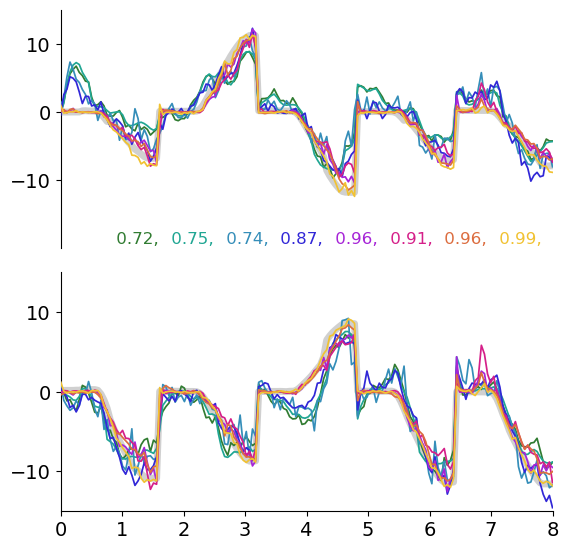

In [3]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2,1,figsize=(5.9,5.8)) #6,5.5
fig.tight_layout()

lw = 1.25
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all0
y_test_predicted = yTestPred_all0

mdls = df0[(df0['outer_fold'] == best_fold) & (df0['downsample_factor'] == 1) & (df0['output_binWidth'] == 50)].index.values
jmdls =[0,1,3,4,5,6,7,8]

conds = conds0[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 7
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)

Nts = 5
plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
#x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000
x = np.linspace(0,Nts*1.6,start_end.shape[0])

axes[0].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.3, linewidth=5, linestyle='solid', label='true (horizontal)',zorder=0)
for n, (i, j) in enumerate(zip(mdls, jmdls)):
    if j!=4:
        axes[0].plot(x,y_test_predicted[i][start_end,0], color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        R2_mod =np.mean([get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]),get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1])])
         
    else:
        axes[0].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        R2_mod = np.mean([get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]])),get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))])
    
    text_box = f" {R2_mod:.2f},"
    axes[0].text(0.2+(n/9), 0.01, text_box, transform=axes[0].transAxes, fontsize=12, ha='right', va='bottom', color=cols[n])

axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-20,15)
axes[0].set_xticks([])
axes[0].set_yticks([-10,0,10])
axes[0].spines['right'].set_color('none')
axes[0].spines['bottom'].set_color('none')
axes[0].spines['top'].set_color('none')

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=5, label='true (horizontal)',zorder=0)
for n, (i, j) in enumerate(zip(mdls, jmdls)):
    if j!=4:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        
axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-15,15)
axes[1].set_yticks([-10,0,10])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.savefig(fig_folder+'/traces_8models-pos.png', dpi=600, bbox_inches='tight')

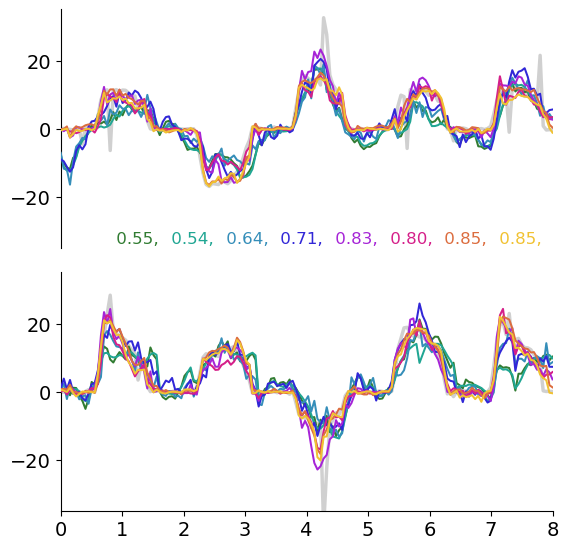

In [4]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2,1,figsize=(5.9,5.8))#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 1.45
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all1
y_test_predicted = yTestPred_all1

mdls = df1[(df1['outer_fold'] == best_fold) & (df1['downsample_factor'] == 1) & (df1['output_binWidth'] == 50)].index.values
jmdls =[0,1,3,4,5,6,7,8]
#Nts = 4

conds = conds1[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

'''
R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 0
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)
'''

#plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
#bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
#x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000
x = np.linspace(0,Nts*1.6,start_end.shape[0])

axes[0].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.3, linewidth=2.5, linestyle='solid', label='true (horizontal)',zorder=0)
for n, (i, j) in enumerate(zip(mdls, jmdls)):
    if j!=4:
        axes[0].plot(x,y_test_predicted[i][start_end,0], color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        R2_mod =np.mean([get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]),get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1])])
         
    else:
        axes[0].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        R2_mod = np.mean([get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]])),get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))])
    
    text_box = f" {R2_mod:.2f},"
    axes[0].text(0.2+(n/9), 0.01, text_box, transform=axes[0].transAxes, fontsize=12, ha='right', va='bottom', color=cols[n])
        
axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-35,35)
axes[0].set_xticks([])
axes[0].set_yticks([-20,0,20])
axes[0].spines['right'].set_color('none')
axes[0].spines['bottom'].set_color('none')
axes[0].spines['top'].set_color('none')

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=2.5, label='true (horizontal)',zorder=0)
for n, (i, j) in enumerate(zip(mdls, jmdls)):
    if j!=4:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        
axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-35,35)
axes[1].set_yticks([-20,0,20])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.savefig(fig_folder+'/traces_8models-vel.png', dpi=600, bbox_inches='tight')

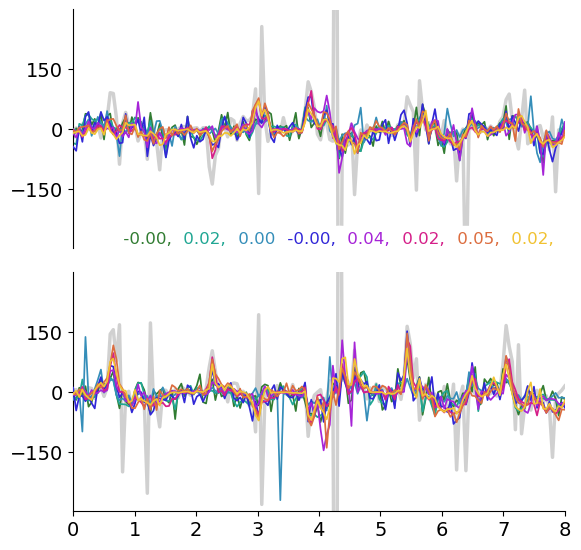

In [5]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2,1,figsize=(5.9,5.8))#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = 1.25
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all2
y_test_predicted = yTestPred_all2

mdls = df2[(df2['outer_fold'] == best_fold) & (df2['downsample_factor'] == 1) & (df2['output_binWidth'] == 50)].index.values
jmdls =[0,1,3,4,5,6,7,8]
#Nts = 4

conds = conds2[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

'''
R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 0
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)
'''

#plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
#bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
#x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000
x = np.linspace(0,Nts*1.6,start_end.shape[0])

axes[0].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.3, linewidth=2.5, linestyle='solid', label='true (horizontal)',zorder=0)
for n, (i, j) in enumerate(zip(mdls, jmdls)):
    if j!=4:
        axes[0].plot(x,y_test_predicted[i][start_end,0], color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        R2_mod =np.mean([get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]),get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1])])
         
    else:
        axes[0].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        R2_mod = np.mean([get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]])),get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))])
    
    text_box = f" {R2_mod:.2f},"
    axes[0].text(0.2+(n/9), 0.01, text_box, transform=axes[0].transAxes, fontsize=12, ha='right', va='bottom', color=cols[n], bbox=dict(facecolor='white', alpha=1, edgecolor='white'))
        
axes[0].set_xlim(x[0],x[-1])
axes[0].set_ylim(-300,300)
axes[0].set_xticks([])
axes[0].set_yticks([-150,0,150])
axes[0].spines['right'].set_color('none')
axes[0].spines['bottom'].set_color('none')
axes[0].spines['top'].set_color('none')

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=2.5, label='true (horizontal)',zorder=0)
for n, (i, j) in enumerate(zip(mdls, jmdls)):
    if j!=4:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
    else:
        axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=cols[n], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        
axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-300,300)
axes[1].set_yticks([-150,0,150])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.savefig(fig_folder+'/traces_8models-acc.png', dpi=600, bbox_inches='tight')

In [ ]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figures-2_4/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-","r0100"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-","r0100"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-","r0100"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
df.head(1)

In [ ]:
mods = [0,1,3,4,5,6,7,8]
outs = ['position','velocity','acceleration']


for m in mods:
    for o in outs:
        subset_1 = df[(df['model']==m) & (df['output']==o) & (df['output_binWidth']==50)]['R2_mn']
        subset_2 = df[(df['model']==m) & (df['output']==o) & (df['output_binWidth']==50)]['R2sh_mn']

        # Perform the Mann-Whitney U test
        statistic, p_value = mannwhitneyu(subset_1, subset_2, alternative='two-sided')
        # Output the test result
        print('{} - {}'.format(m,o))
        print(f"P-value: {p_value}")
        if 1.00e-02 < p_value <= 5.00e-02:
            print('*')
        elif 1.00e-03 < p_value <= 1.00e-02:
            print('**')
        elif 1.00e-04 < p_value <= 1.00e-03:
            print('***')
        elif p_value <= 1.00e-04:
            print('****')
        else:
            print('ns')
        print('\n')

In [ ]:
########################################### position ##########################################
values = ['R2_mn','R2sh_mn']
b = 50
o = 'position'

wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values

n=10
means=([np.mean(wf,axis=0),np.mean(wc,axis=0),np.mean(xgb,axis=0),np.mean(svr,axis=0),np.mean(dnn,axis=0),np.mean(rnn,axis=0),np.mean(gru,axis=0),np.mean(lstm,axis=0)])
err=([np.std(wf,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(wc,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(xgb,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(svr,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(dnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(rnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(gru,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(lstm,axis=0)*np.sqrt(1./n+1./(n-1))])
ind = np.arange(len(err)) #X values for plotting


# Standard R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 3), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, cols): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, capthick=2, color=color, zorder=1)

    ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(cols[j])
        
    #jittered_x = [x + np.random.uniform(-0.2, 0.2) for x in scatter_x]
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.075,zorder=0)
    ax.set_yticks([0.5,0.6,0.7,0.8,0.9])

ax.set_ylim(0.4,0.9);
fig.savefig(fig_folder+'/mnR2_8models-pos.png', dpi=600, bbox_inches='tight')

# Shuffled R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 1.5), sharey=True)
fig.tight_layout()
val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    markers, caps, bars = ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, capthick=2, color=color, alpha=1, zorder=1)
  #  [bar.set_alpha(0.1) for bar in bars]
   # [cap.set_alpha(0.1) for cap in caps]
    
    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,alpha=0.1,marker='x',zorder=0)

ax.set_ylim(-1.25,-0.1);
ax.set_yticks([-1.0,-0.5])
fig.savefig(fig_folder+'/mnR2_8models-posnull.png', dpi=600, bbox_inches='tight')

In [ ]:
########################################### velocity ##########################################
values = ['R2_mn','R2sh_mn']
b = 50
o = 'velocity'

wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values

n=10
means=([np.mean(wf,axis=0),np.mean(wc,axis=0),np.mean(xgb,axis=0),np.mean(svr,axis=0),np.mean(dnn,axis=0),np.mean(rnn,axis=0),np.mean(gru,axis=0),np.mean(lstm,axis=0)])
err=([np.std(wf,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(wc,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(xgb,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(svr,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(dnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(rnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(gru,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(lstm,axis=0)*np.sqrt(1./n+1./(n-1))])
ind = np.arange(len(err)) #X values for plotting

# Standard R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 3), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, cols): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, capthick=2, color=color, zorder=1)

    ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(cols[j])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.075,zorder=0)
    ax.set_yticks([0.5,0.6,0.7,0.8,0.9])

ax.set_ylim(0.4,0.9);
fig.savefig(fig_folder+'/mnR2_8models-vel.png', dpi=600, bbox_inches='tight')

# Shuffled R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 1.5), sharey=True)
fig.tight_layout()
val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, capthick=2, alpha=1,color=color, zorder=1)

    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.1,zorder=0)

ax.set_ylim(-1.25,-0.1);
ax.set_yticks([-1.0,-0.5])
fig.savefig(fig_folder+'/mnR2_8models-velnull.png', dpi=600, bbox_inches='tight')

In [ ]:
########################################### acceleration ##########################################
values = ['R2_mn','R2sh_mn']
b = 50
o = 'acceleration'


wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['output_binWidth']==b)]).groupby(['outer_fold'])[values].mean().values

n=10
means=([np.mean(wf,axis=0),np.mean(wc,axis=0),np.mean(xgb,axis=0),np.mean(svr,axis=0),np.mean(dnn,axis=0),np.mean(rnn,axis=0),np.mean(gru,axis=0),np.mean(lstm,axis=0)])
err=([np.std(wf,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(wc,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(xgb,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(svr,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(dnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(rnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(gru,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(lstm,axis=0)*np.sqrt(1./n+1./(n-1))])
ind = np.arange(len(err)) #X values for plotting

# positive R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 1.2), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, cols): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, capthick=2, color=color, zorder=0)

    ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    #ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(cols[j])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.05,zorder=1)
ax.set_yticks([0.9])
#ax.set_yticks([-1.0,-0.5,0,0.5,0.6,0.7,0.8,0.9,1.0])

ax.set_ylim(0.8,0.9);
#fig.savefig(fig_folder+'/mnR2_8models-acc.png', dpi=600, bbox_inches='tight')

val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, capthick=2, color=color, zorder=0)

    #ax.set_xticks([0,1,2,3,4,5,6,7])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=1,zorder=1)

fig.savefig(fig_folder+'/mnR2_8models-acc.png', dpi=600, bbox_inches='tight')

#################################################################################################
# negative R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 2.5), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, cols): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, capthick=2, color=color, zorder=1)

    #ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    #ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(cols[j])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.075,zorder=0)
ax.set_yticks([-0.05,0,0.05])
#ax.set_yticks([-1.0,-0.5,0,0.5,0.6,0.7,0.8,0.9,1.0])

ax.set_ylim(-0.1,0.1);
#fig.savefig(fig_folder+'/mnR2_8models-acc.png', dpi=600, bbox_inches='tight')

val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, alpha=1,capthick=2, color=color, zorder=1)

    ax.set_xticks([])
    #ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.1,zorder=0)

fig.savefig(fig_folder+'/mnR2_8models-accnull.png', dpi=600, bbox_inches='tight')

########################################################################################
# negative R2
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1, figsize=(5.5, 1.3), sharey=True)
fig.tight_layout()

val = 1

for pos, y, yerr, color in zip(ind, means, err, grays): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=2, capsize=5, alpha=1,capthick=2, color=color, zorder=1)

    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(grays[j])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.1,zorder=0)
ax.set_ylim(-1.25,-0.2);
ax.set_yticks([-1.0,-0.5])

fig.savefig(fig_folder+'/mnR2_8models-accnullBelow.png', dpi=600, bbox_inches='tight')

# Figure 4: How do output params affect decoding performance?

In [ ]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figures-2_4/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==7)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']

df['train_time'] = df['train_time'] / 60

df.head(1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=False)#, gridspec_kw={'height_ratios': [3, 2]})

#plt.subplots_adjust(hspace=0.1)

num_bins = 10
mayo = 0
behs = ['R2_mn'] #, 'train_time'
kins = ['position', 'velocity', 'acceleration']

for k, kin in enumerate(kins):
    DF = df.loc[(df['output'] == kin) & (df['output_binWidth']!=0) & (df['R2_mn'] >-1)]

    for i, beh in enumerate(behs):
        dff = DF[['model', 'output_binWidth', beh, 'outer_fold']]
        obw = dff['output_binWidth'].unique()

        df_mn = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
        df_sd = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].std().reset_index(name="sR2")

        for i,m in enumerate(DF['model'].unique()):
            mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
            mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

            # Get the centers of the bins for x-values
            bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)]['output_binWidth']]
            bin_mins = [bin.left for bin in df_mn[(df_mn['model'] == m)]['output_binWidth']]
            bin_maxs = [bin.right for bin in df_mn[(df_mn['model'] == m)]['output_binWidth']]
            
            # Round bin min and max values to the nearest integer
            bin_mins = [round(val) for val in bin_mins]
            bin_maxs = [round(val) for val in bin_maxs]

            ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=2)
            ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=3)

            # Set the x-tick labels as bin minimum and maximum for each point
            x_tick_labels = [f"[{min_val}-{max_val})" for min_val, max_val in zip(bin_mins, bin_maxs)]
            ax[k].set_xticks(bin_centers)
            ax[k].set_xticklabels(x_tick_labels, rotation=45)
            
        ax[k].spines['right'].set_color('none')
        ax[k].spines['top'].set_color('none')
    ax[0].set_ylim(0.33,0.92)
    ax[1].set_ylim(0.33,0.92)
    ax[2].set_ylim(-0.15,0.51)
    ax[0].set_yticks([0.4,0.5,0.6,0.7,0.8,0.9])
    ax[1].set_yticks([0.4,0.5,0.6,0.7,0.8,0.9])
    ax[2].set_yticks([-0.1,0,0.1,0.2,0.3])
    
    #ax[1, k].set_ylim(0,325)
    #ax[1, 1].set_yticks([])
    #ax[1, 2].set_yticks([])
    
plt.subplots_adjust(wspace=0.25, hspace=0.1)

if mayo==1:
    ax[0].set_ylabel('$R^2$')
    #ax[1, 0].set_ylabel('time elapsed (s)')
    ax[1].set_xlabel('output bin width (ms)')
    ax[0].set_title('position')
    ax[1].set_title('velocity')
    ax[2].set_title('acceleration')
else:
    blah = 1
    fig.savefig(fig_folder+'/r2tt_outputBinWidth-onesess.png', dpi=600, bbox_inches='tight') 


In [ ]:
bws = [10,50,100,300]
mayo = 0
Nts = 6

plt.rcParams.update({'font.size': 23})
fig, axes = plt.subplots(len(bws),3,figsize=(20,20), sharex=True, sharey=False)#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

lw = [1.5,1.75,2.25,2.5]
mdls = df0[(df0['outer_fold'] == best_fold) & (df0['output_binWidth'] == 50) & (df0['R2_mn']>-1)].index.values
jmdls =[0,1,3,4,5,6,7]

conds = conds0[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

y_test = yTest_all0
y_test_predicted = yTestPred_all0
    
R2_all,trl_names = [],[]
for t in trl_nums[1:-1]:
    start_end = np.where(np.isin(conds[:, 0],t))[0]

    i = 4
    X_true = y_test[mdls[i]][start_end,0]
    Y_true = y_test[mdls[i]][start_end,1]

    X_pred = y_test_predicted[mdls[i]][start_end,0]
    Y_pred = y_test_predicted[mdls[i]][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
    R2_all.append(R2[1])
    trl_names.append(t)

R2_all = np.array(R2_all)
trl_names = np.array(trl_names)

plot_trls = trl_names[np.argsort(R2_all)[-Nts:]]
bad_trls = trl_names[np.argsort(R2_all)[:Nts]]

#################
R2_allParams = np.zeros((len(bws),3))
for b, bw in enumerate(bws):
    for k in range(3):
        if k==0:
            y_test = yTest_all0
            y_test_predicted = yTestPred_all0
            DF = df0
        elif k==1:
            y_test = yTest_all1
            y_test_predicted = yTestPred_all1
            DF = df1
        else:
            y_test = yTest_all2
            y_test_predicted = yTestPred_all2
            DF = df2
            
        mdls = DF[(DF['outer_fold'] == best_fold) & (DF['output_binWidth'] == bw) & (DF['R2_mn']>-1)].index.values
        jmdls =[0,1,3,4,5,6,7]

        conds = conds0[mdls[0]]
        trl_nums = np.unique(conds[:,0])
        trl_nums, indices = np.unique(conds[:,0], return_index=True)

        start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
        #x = np.arange(0, start_end.shape[0]*bw*Nts, bw*Nts)*2 / 10000
        x = np.linspace(0,Nts*1.6,start_end.shape[0])
        
        axes[b,k].plot(x,y_test[mdls[0]][start_end,0], color=(0.4,0.4,0.4), alpha=0.3, linewidth=lw[b]*2, linestyle='solid',label='true (horizontal)',zorder=0)
        for i,j in zip(mdls,jmdls):
            if j!=4:
                axes[b,k].plot(x,y_test_predicted[i][start_end,0], color=cols[j], linewidth=lw[b], linestyle='solid', label='predicted (horizontal)',zorder=j+1)
                R2_allParams[b,k] = get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0])
            else:
                axes[b,k].plot(x,y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]), color=cols[j], linewidth=lw[b], linestyle='solid', label='predicted (horizontal)',zorder=j+1)
                R2_allParams[b,k] = get_R2(y_test[mdls[0]][start_end,0],y_test_predicted[i][start_end,0]*np.std(y_test[mdls[0]]))
        
            if j==6:
                text_box = f"$R^2$ = {R2_allParams[b, k]:.3f}"
                axes[b, k].text(0.97, 0.01, text_box, transform=axes[b, k].transAxes, fontsize=22, ha='right', va='bottom', color=cols[j])
        
        axes[b,k].spines['right'].set_color('none')
        axes[b,k].spines['top'].set_color('none')
        axes[b,k].set_yticks([round(min(y_test[i][start_end,0])),0,round(max(y_test[i][start_end,0]))])
        
        if k==0:
            axes[b, k].margins(y=0.1)
        elif k==1:
            axes[b, k].margins(y=0.2)
        else:
            axes[b, k].margins(y=0.1)
        
        
    if mayo==1:
        axes[b,0].set_ylabel(f'bw={bw}')
        
axes[0,0].set_xticks([0,2,4,6,8,10])

plt.subplots_adjust(wspace=0.25, hspace=0.02)
if mayo==1:
    axes[0, 0].set_title('position')
    axes[0, 1].set_title('velocity')
    axes[0, 2].set_title('acceleration')
    axes[3, 1].set_xlabel('time (ms)')
else:
    blah = 1
    fig.savefig(fig_folder+'/traces_outBinWidth-posVelAcc.png', dpi=600, bbox_inches='tight')
    

# Figure 5: How do input params affect decoding performance?

In [ ]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figure5/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==0)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']

df['train_time'] = df['train_time'] / 60

df = df[df['R2_mn'] >= 0]

df.head(1)

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

# Define the desired number of bins in x and y axes
desired_x_bins = 9 #9
desired_y_bins = 7 #7
bin_type = 0 # 0 = set-width, 1 = even-quantity
mdls = ['wf','wc','kf','xgb','svr','dnn','rnn','gru','lstm']
mayo = 0

df = df[df['R2_mn'] >= 0]
x_edges = [10, 20, 30, 40, 60, 90, 130, 200, 300]
y_edges = [10, 120, 210, 280, 360, 450, 540, 640]

################# POSITION ###################
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(8,3, figsize=(11,20), sharex=True, sharey=True)
fig.tight_layout()

col = 0
for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='position')  & (df['model']==m)]
    dff = DF[['R2_mn','input_binWidth','input_timeWindow']]
    #dff = dff.loc[(df['input_binWidth']>40) & (df['input_binWidth']<160) & (df['input_timeWindow']>79) & (df['input_timeWindow']<401)]

    if bin_type==0:
        df_m = dff.groupby([
            pd.cut(dff['input_binWidth'], bins=x_edges, include_lowest=True),
            pd.cut(dff['input_timeWindow'], bins=y_edges, include_lowest=True)
        ])["R2_mn"].mean().reset_index(name="R2")
        
    elif bin_type==1:
        df_m = dff.groupby([
            pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
            pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
        ])["R2_mn"].mean().reset_index(name="R2")
    
    # Pivot the data for heatmap
    result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
    
    R2_values = result.values.astype(float)
    # Normalize the values using Min-Max scaler
    scaler = MinMaxScaler()
    normalized_values = scaler.fit_transform(R2_values)
    result2 = result.copy()
    result2.loc[:, :] = normalized_values
    
    x_labels = [f'({int(col.left) + 1}-{int(col.right)}]' if col == result.columns[0] else f'({int(col.left)}-{int(col.right)})' for col in result.columns]
    y_labels = [f'({int(index.left) + 1}-{int(index.right)}]' if index == result.index[0] else f'({int(index.left)}-{int(index.right)})' for index in result.index]


    
    a = sns.heatmap(ax=ax[i,col], data=result2, cmap=pals[i], mask=result2.isnull(), alpha=0.9,
                    vmin=0, vmax=1, cbar=False, xticklabels=x_labels, yticklabels=y_labels)

    # Add custom annotations and outline for minimum and maximum values
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            value = result.iloc[y, x]
            if value == np.min(result):
                a.text(x + 0.5, y + 0.5, f'{value:.2f}'.lstrip('0'), ha='center', va='center', color='black', fontsize=13)
                a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor=cols[i], facecolor='none', lw=1))
            elif value == np.max(result):
                a.text(x + 0.5, y + 0.5, f'{value:.2f}'.lstrip('0'), ha='center', va='center', color='black', fontsize=13)
                a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', lw=1))
            else:
                blh = 0
                #a.text(x + 0.5, y + 0.5, f'{value:.2f}', ha='center', va='center', color='white')

    
    #, vmin=0.42, vmax=0.91,
    a.invert_yaxis()
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="center")
    
    if mayo==0:
        a.set(xlabel=None)
        a.set(ylabel=None)
    else:
        a.set_title('position', pad=30)  

################# VELOCITY ###################
#plt.rcParams.update({'font.size': 12})
#fig, ax = plt.subplots(1,8, figsize=(20,3), sharex=True, sharey=True)
#fig.tight_layout()

col = 1
for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='velocity')  & (df['model']==m)]
    dff = DF[['R2_mn','input_binWidth','input_timeWindow']]
    #dff = dff.loc[(df['input_binWidth']>40) & (df['input_binWidth']<160) & (df['input_timeWindow']>79) & (df['input_timeWindow']<401)]

    if bin_type==0:
        df_m = dff.groupby([
            pd.cut(dff['input_binWidth'], bins=x_edges, include_lowest=True),
            pd.cut(dff['input_timeWindow'], bins=y_edges, include_lowest=True)
        ])["R2_mn"].mean().reset_index(name="R2")
    elif bin_type==1:
        df_m = dff.groupby([
            pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
            pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
        ])["R2_mn"].mean().reset_index(name="R2")
    
    # Pivot the data for heatmap
    result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
    R2_values = result.values.astype(float)
    # Normalize the values using Min-Max scaler
    scaler = MinMaxScaler()
    normalized_values = scaler.fit_transform(R2_values)
    result2 = result.copy()
    result2.loc[:, :] = normalized_values
    
    x_labels = [f'({int(col.left) + 1}-{int(col.right)}]' if col == result.columns[0] else f'({int(col.left)}-{int(col.right)})' for col in result.columns]
    y_labels = [f'({int(index.left) + 1}-{int(index.right)}]' if index == result.index[0] else f'({int(index.left)}-{int(index.right)})' for index in result.index]

    

    a = sns.heatmap(ax=ax[i,col], data=result2, cmap=pals[i], mask=result2.isnull(), alpha=0.9,
                    vmin=0, vmax=1, cbar=False, xticklabels=x_labels, yticklabels=y_labels)

    # Add custom annotations and outline for minimum and maximum values
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            value = result.iloc[y, x]
            if value == np.min(result):
                a.text(x + 0.5, y + 0.5, f'{value:.2f}'.lstrip('0'), ha='center', va='center', color='black', fontsize=13)
                a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor=cols[i], facecolor='none', lw=1))
            elif value == np.max(result):
                a.text(x + 0.5, y + 0.5, f'{value:.2f}'.lstrip('0'), ha='center', va='center', color='black', fontsize=13)
                a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', lw=1))
            else:
                blh = 0
                #a.text(x + 0.5, y + 0.5, f'{value:.2f}', ha='center', va='center', color='white')

    
    #, vmin=0.42, vmax=0.91,
    a.invert_yaxis()
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="center")
    if mayo==0:
        a.set(xlabel=None)
        a.set(ylabel=None)
    else:
        a.set_title('velocity', pad=30)  
   
        
################# ACCELERATION ###################
#plt.rcParams.update({'font.size': 12})
#fig, ax = plt.subplots(1,8, figsize=(20,3), sharex=True, sharey=True)
#fig.tight_layout()

col = 2
for i,m in enumerate(df['model'].unique()):
    
    DF = df.loc[(df['output']=='acceleration')  & (df['model']==m)]
    dff = DF[['R2_mn','input_binWidth','input_timeWindow']]
    #dff = dff.loc[(df['input_binWidth']>40) & (df['input_binWidth']<160) & (df['input_timeWindow']>79) & (df['input_timeWindow']<401)]

    if bin_type==0:
        df_m = dff.groupby([
            pd.cut(dff['input_binWidth'], bins=x_edges, include_lowest=True),
            pd.cut(dff['input_timeWindow'], bins=y_edges, include_lowest=True)
        ])["R2_mn"].mean().reset_index(name="R2")
    elif bin_type==1:
        df_m = dff.groupby([
            pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
            pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
        ])["R2_mn"].mean().reset_index(name="R2")
    
    # Pivot the data for heatmap
    result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
    R2_values = result.values.astype(float)
    # Normalize the values using Min-Max scaler
    scaler = MinMaxScaler()
    normalized_values = scaler.fit_transform(R2_values)
    result2 = result.copy()
    result2.loc[:, :] = normalized_values
    
    x_labels = [f'({int(col.left) + 1}-{int(col.right)}]' if col == result.columns[0] else f'({int(col.left)}-{int(col.right)})' for col in result.columns]
    y_labels = [f'({int(index.left) + 1}-{int(index.right)}]' if index == result.index[0] else f'({int(index.left)}-{int(index.right)})' for index in result.index]


    a = sns.heatmap(ax=ax[i,col], data=result2, cmap=pals[i], mask=result2.isnull(), alpha=0.9,
                    vmin=0, vmax=1, xticklabels=x_labels, yticklabels=y_labels,
                    cbar_kws={'location': 'right', 'ticks': [0, 1],
                            'orientation': 'vertical', 'pad': 0.01, "shrink": 0.75,
                            'format': ticker.FuncFormatter(lambda x, pos: f'{x:.0f}')})

    # Add custom annotations and outline for minimum and maximum values
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            value = result.iloc[y, x]
            
            if value == np.min(result):
                a.text(x + 0.5, y + 0.5, f'{value:.2f}'.lstrip('0'), ha='center', va='center', color='black', fontsize=13)
                a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor=cols[i], facecolor='none', lw=1))
            elif value == np.max(result):
                a.text(x + 0.5, y + 0.5, f'{value:.2f}'.lstrip('0'), ha='center', va='center', color='black', fontsize=13)
                a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', lw=1))
            else:
                blh = 0
                #a.text(x + 0.5, y + 0.5, f'{value:.2f}', ha='center', va='center', color='white')

    
    #, vmin=0.42, vmax=0.91,
    a.invert_yaxis()
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="center")

    if mayo==0:
        a.set(xlabel=None)
        a.set(ylabel=None)
    else:
        a.set_title('acceleration', pad=30)
        
plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.savefig(fig_folder+'/r2htmp_inBinWidth-posVelAcc.png', dpi=600, bbox_inches='tight')

# Figure 6: How does the number of units affect performance?

In [2]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figure6/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time','neuron_inds']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==0)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']

df['train_time'] = df['train_time'] / 60
df = df.drop('nFEF',axis=1)
df = df.rename(columns={'nMT': 'numNeurons'})

df = df[df['R2_mn'] >= -1.5]

df.head(10)

,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,model,output,numNeurons,repeat,...,rho_mn,R2sh_x,R2sh_y,R2sh_mn,R2tr_x,R2tr_y,R2tr_mn,num_bins,preProcessTime_corrected,inference_time
0,29,0,100,1,400,50,0,position,5,0,...,0.471133,-0.148935,-0.159543,-0.154239,0.163240,0.196009,0.179625,38176.0,0.174984,0.175731
1,29,0,100,1,400,50,0,position,5,1,...,0.261570,-0.046353,-0.069040,-0.057697,0.060692,0.114438,0.087565,38176.0,0.174984,0.175507
2,29,0,100,1,400,50,0,position,5,2,...,0.315547,-0.098035,-0.039989,-0.069012,0.176879,0.047720,0.112299,38176.0,0.174984,0.175685
3,29,0,100,1,400,50,0,position,5,3,...,0.407222,-0.075963,-0.145377,-0.110670,0.119869,0.212703,0.166286,38176.0,0.174984,0.175677
4,29,0,100,1,400,50,0,position,5,4,...,0.205431,-0.022610,-0.061191,-0.041901,0.069460,0.076775,0.073117,38176.0,0.174984,0.175678
5,29,0,100,1,400,50,0,position,5,5,...,0.400044,-0.035565,-0.183041,-0.109303,0.069645,0.334983,0.202314,38176.0,0.174984,0.175680
6,29,0,100,1,400,50,0,position,5,6,...,0.425864,-0.060579,-0.175287,-0.117933,0.080200,0.337449,0.208824,38176.0,0.174984,0.175478
7,29,0,100,1,400,50,0,position,5,7,...,0.425354,-0.054780,-0.121202,-0.087991,0.107105,0.207760,0.157432,38176.0,0.174984,0.175825
8,29,0,100,1,400,50,0,position,5,8,...,0.483347,-0.109276,-0.166370,-0.137823,0.167363,0.354838,0.261101,38176.0,0.174984,0.175834
9,29,0,100,1,400,50,0,position,5,9,...,0.492967,-0.042923,-0.173080,-0.108001,0.114633,0.373309,0.243971,38176.0,0.174984,0.175778


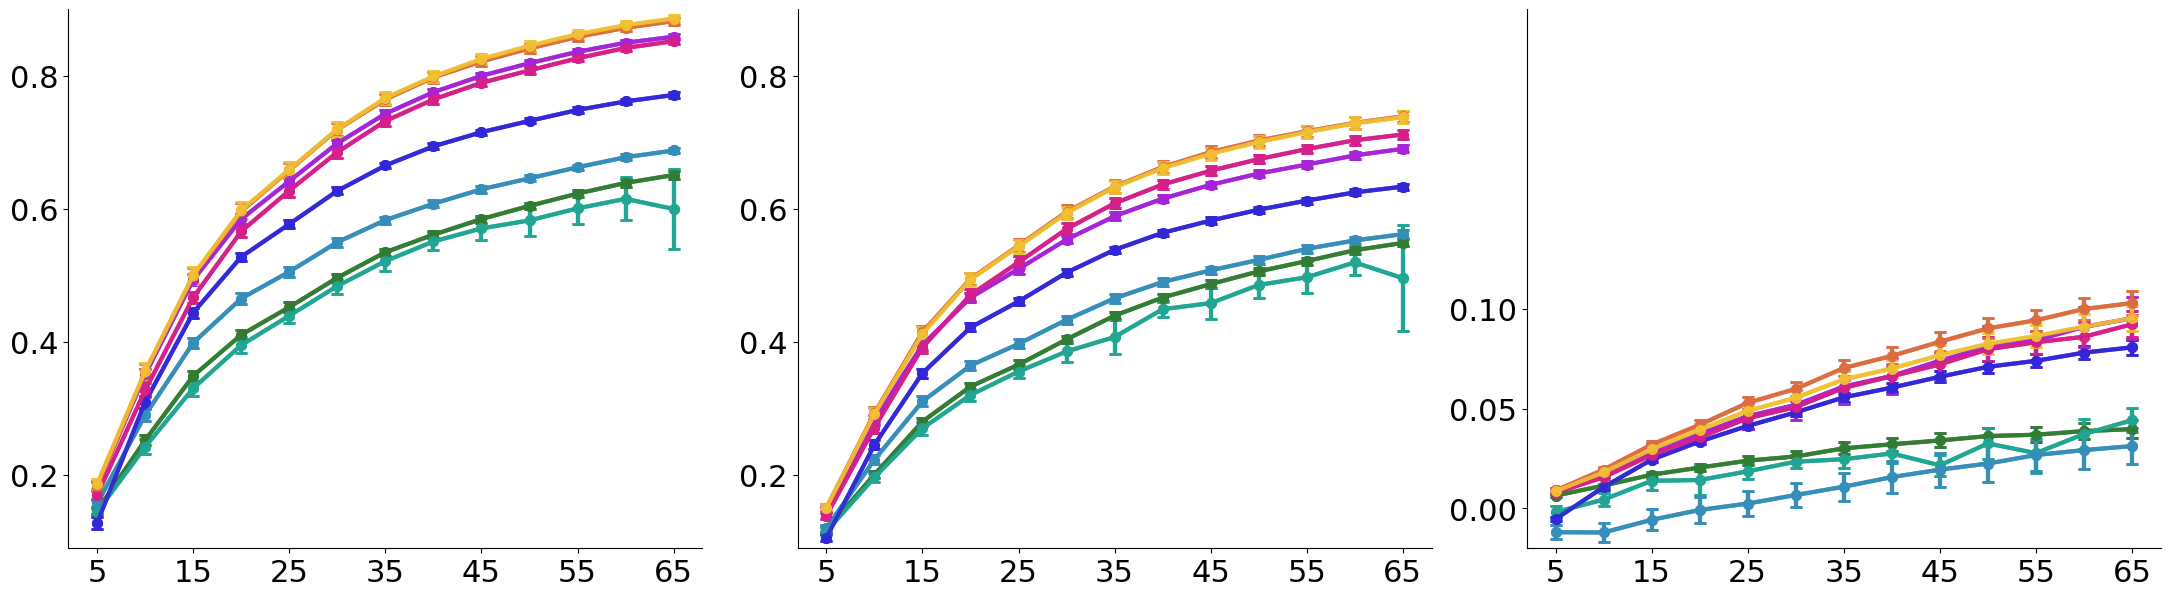

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 3, figsize=(27, 7), sharex=True, sharey=False)#, gridspec_kw={'height_ratios': [3, 2]})

#plt.subplots_adjust(hspace=0.1)

num_bins = 13
mayo = 0
behs = ['R2_mn'] #, 'train_time'
kins = ['position', 'velocity', 'acceleration']

for k, kin in enumerate(kins):
    DF = df.loc[(df['output'] == kin)]

    for i, beh in enumerate(behs):
        dff = DF[['model', 'numNeurons', beh, 'outer_fold','repeat']]
        dff = dff.groupby(['model', 'numNeurons', 'outer_fold'])['R2_mn'].mean().reset_index()
        obw = dff['numNeurons'].unique()

        if num_bins==13:
            df_mn = dff.groupby(['model', 'numNeurons'])[beh].mean().reset_index(name="mR2")
            df_sd = dff.groupby(['model', 'numNeurons'])[beh].std().reset_index(name="sR2")
        else:
            df_mn = dff.groupby(['model', pd.cut(dff['numNeurons'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
            df_sd = dff.groupby(['model', pd.cut(dff['numNeurons'], bins=num_bins)])[beh].std().reset_index(name="sR2")
          
        for i,m in enumerate(DF['model'].unique()):
            mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
            mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

            if num_bins==13:
                ax[k].errorbar(obw, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=2)
                ax[k].errorbar(obw, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=3)
                
                # Set the x-tick labels as bin minimum and maximum for each point
                x_tick_labels = obw
                ax[k].set_xticks(obw)
                ax[k].set_xticklabels(x_tick_labels, rotation=0)
            else:    
                # Get the centers of the bins for x-values
                bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)]['numNeurons']]
                bin_mins = [bin.left for bin in df_mn[(df_mn['model'] == m)]['numNeurons']]
                bin_maxs = [bin.right for bin in df_mn[(df_mn['model'] == m)]['numNeurons']]

                # Round bin min and max values to the nearest integer
                bin_mins = [round(val) for val in bin_mins]
                bin_maxs = [round(val) for val in bin_maxs]

                ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=2)
                ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=3)

                # Set the x-tick labels as bin minimum and maximum for each point
                x_tick_labels = [f"[{min_val}-{max_val})" for min_val, max_val in zip(bin_mins, bin_maxs)]
                #x_tick_labels = bin_mins
                ax[k].set_xticks(bin_centers)
                ax[k].set_xticklabels(x_tick_labels, rotation=45)
            
        ax[k].spines['right'].set_color('none')
        ax[k].spines['top'].set_color('none')
    
plt.subplots_adjust(wspace=0.15, hspace=0.1)
ax[2].set_xticks([5,15,25,35,45,55,65])

ax[0].set_yticks([0,0.2,0.4,0.6,0.8])
ax[0].set_ylim(0.09,0.9)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8])
ax[1].set_ylim(0.09,0.9)
ax[2].set_yticks([0,0.05,0.1])
ax[2].set_ylim(-0.02,0.25)

if mayo==1:
    ax[0].set_ylabel('$R^2$')
    #ax[1, 0].set_ylabel('time elapsed (s)')
    ax[1].set_xlabel('number of neurons')
    ax[0].set_title('position')
    ax[1].set_title('velocity')
    ax[2].set_title('acceleration')
else:
    blah = 1
    fig.savefig(fig_folder+'/r2_numNeurons-onesess.png', dpi=600, bbox_inches='tight') 

# Figure 7: How do these params all affect computational load?

What are the effects of dataset size and data quality on how well the model can efficiently run and generalize well to unseen data?

As the model becomes more complex or flexible, it can memorize the training data (overfitting) rather than generalizing patterns.
A large training-test gap indicates overfitting, where the model performs very well on the training data but poorly on unseen test data.
A small training-test gap indicates better generalization, where the model generalizes well to new data.
While a large training-test gap is often indicative of overfitting, it doesn't necessarily mean that overfitting has occurred. Other factors such as dataset size, data quality, and the inherent complexity of the problem can influence the gap.

In [4]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figures-2_4/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["s29-"],column_names)

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']
df['num_inputBins'] = df['input_timeWindow'] / df['input_binWidth']

df['train_time'] = df['train_time'] / 60
df0 = df[df['R2_mn'] >= 0]
df0.head(1)

####################################################
sub_folder = 'figure5/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df, _, _, _ = get_outputs_wTraces(data_folder+sub_folder,["s29-"],column_names)

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']
df['num_inputBins'] = df['input_timeWindow'] / df['input_binWidth']


df['train_time'] = df['train_time'] / 60
df1 = df[df['R2_mn'] >= 0]
df1.head(1)

######################################################
sub_folder = 'figure6/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time','neuron_inds']
df, _, _, _ = get_outputs_wTraces(data_folder+sub_folder,["s29-"],column_names)

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']
df['num_inputBins'] = df['input_timeWindow'] / df['input_binWidth']

df['train_time'] = df['train_time'] / 60
df = df.drop('nFEF',axis=1)
df = df.rename(columns={'nMT': 'numNeurons'})

df2 = df[df['R2_mn'] >= 0]
df2.head(10)

,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,model,output,numNeurons,repeat,...,R2sh_x,R2sh_y,R2sh_mn,R2tr_x,R2tr_y,R2tr_mn,num_bins,preProcessTime_corrected,inference_time,num_inputBins
0,29,0,100,1,400,50,0,position,5,0,...,-0.148935,-0.159543,-0.154239,0.163240,0.196009,0.179625,38176.0,0.174984,0.175731,8.0
1,29,0,100,1,400,50,0,position,5,1,...,-0.046353,-0.069040,-0.057697,0.060692,0.114438,0.087565,38176.0,0.174984,0.175507,8.0
2,29,0,100,1,400,50,0,position,5,2,...,-0.098035,-0.039989,-0.069012,0.176879,0.047720,0.112299,38176.0,0.174984,0.175685,8.0
3,29,0,100,1,400,50,0,position,5,3,...,-0.075963,-0.145377,-0.110670,0.119869,0.212703,0.166286,38176.0,0.174984,0.175677,8.0
4,29,0,100,1,400,50,0,position,5,4,...,-0.022610,-0.061191,-0.041901,0.069460,0.076775,0.073117,38176.0,0.174984,0.175678,8.0
5,29,0,100,1,400,50,0,position,5,5,...,-0.035565,-0.183041,-0.109303,0.069645,0.334983,0.202314,38176.0,0.174984,0.175680,8.0
6,29,0,100,1,400,50,0,position,5,6,...,-0.060579,-0.175287,-0.117933,0.080200,0.337449,0.208824,38176.0,0.174984,0.175478,8.0
7,29,0,100,1,400,50,0,position,5,7,...,-0.054780,-0.121202,-0.087991,0.107105,0.207760,0.157432,38176.0,0.174984,0.175825,8.0
8,29,0,100,1,400,50,0,position,5,8,...,-0.109276,-0.166370,-0.137823,0.167363,0.354838,0.261101,38176.0,0.174984,0.175834,8.0
9,29,0,100,1,400,50,0,position,5,9,...,-0.042923,-0.173080,-0.108001,0.114633,0.373309,0.243971,38176.0,0.174984,0.175778,8.0


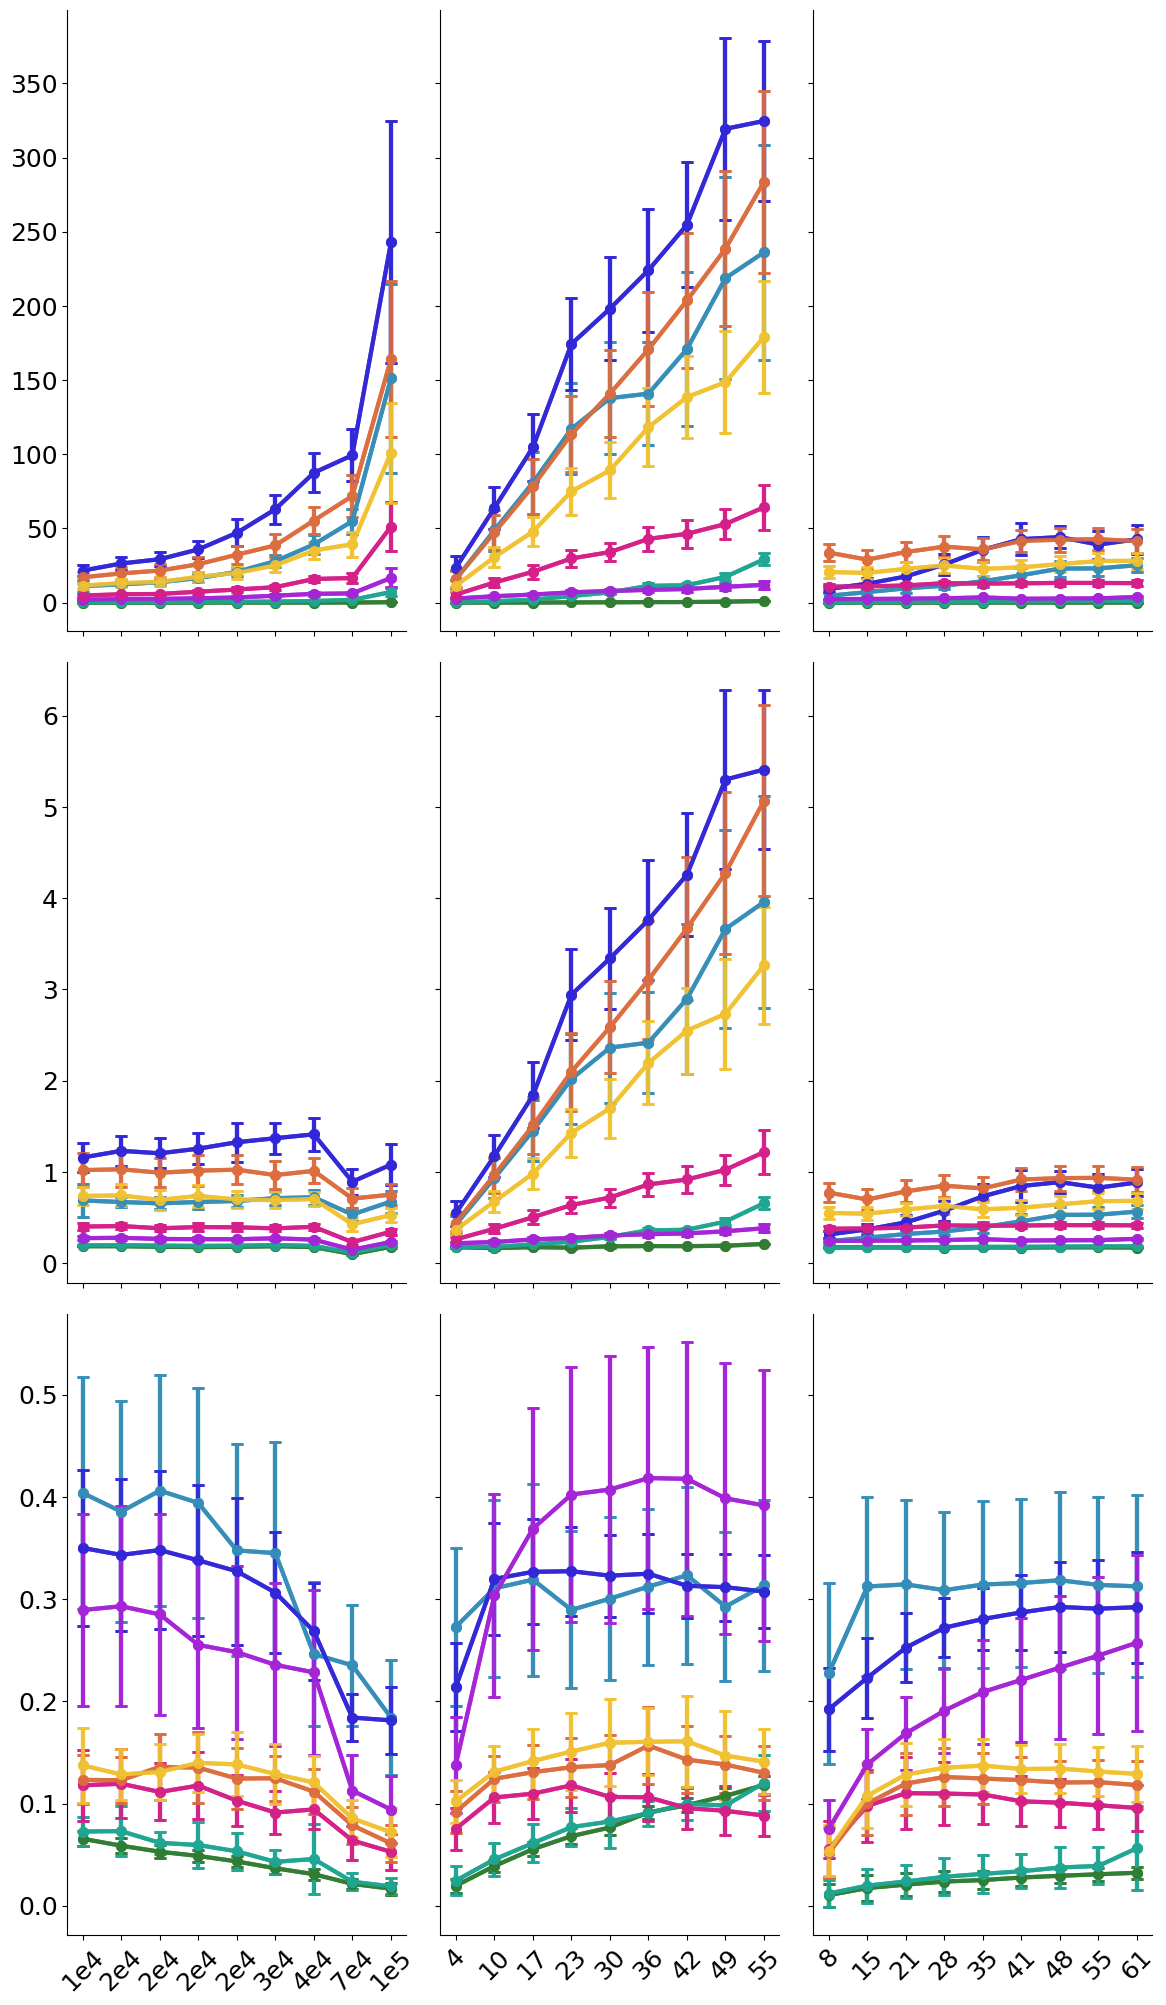

In [5]:
# y-axis = training time, inference latency, train-test gap 
# Disable the "SettingWithCopyWarning"
pd.options.mode.chained_assignment = None  # 'warn' or None

num_bins = 9
mayo = 0
behs = ['train_time','inference_time','robust_diff'] #, 'train_time'
varbls = ['num_obs','num_feat','numNeurons']
kin = 'position'

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(len(behs), len(varbls), figsize=(14, 25), sharex='col', sharey='row')#, gridspec_kw={'height_ratios': [3, 2]})

x_edges = [10, 20, 30, 40, 60, 90, 130, 200, 300]
y_edges = [10, 120, 210, 280, 360, 450, 540, 640]

for v, vr in enumerate(varbls):
    if v==0:
        DF = df0
    elif v==1:
        DF = df1
    else:
        DF = df2
     
    #DF = DF.loc[(DF['output'] == kin)]
    DF['num_obs'] = DF['output_binWidth'].copy()
    DF['num_feat'] = DF['input_timeWindow'] / DF['input_binWidth']
    DF['robust_diff'] = (DF['R2tr_mn'] - DF['R2_mn'])
        
    for k, beh in enumerate(behs):
        dff = DF[['model', vr, beh, 'outer_fold']]
        obw = dff[vr].unique()

        df_mn = dff.groupby(['model', pd.cut(dff[vr], bins=num_bins)])[beh].mean().reset_index(name="mR2")
        df_sd = dff.groupby(['model', pd.cut(dff[vr], bins=num_bins)])[beh].std().reset_index(name="sR2")

        for i,m in enumerate(DF['model'].unique()):
            mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
            mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

            # Get the centers of the bins for x-values
            bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)][vr]]
            bin_mins = [bin.left for bin in df_mn[(df_mn['model'] == m)][vr]]
            bin_maxs = [bin.right for bin in df_mn[(df_mn['model'] == m)][vr]]

            # Round bin min and max values to the nearest integer
            bin_mins = [round(val) for val in bin_mins]
            bin_maxs = [round(val) for val in bin_maxs]
            

            ax[k,v].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=2)
            ax[k,v].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=4, marker='o', alpha=0.9, markersize=7, capthick=2, color=cols[i], zorder=3)

            # Set the x-tick labels as bin minimum and maximum for each point
            #x_tick_labels = [f"[{min_val}-{max_val})" for min_val, max_val in zip(bin_mins, bin_maxs)]
            #ax[k,v].set_xticks(bin_centers)
            #ax[k,v].set_xticklabels(x_tick_labels, rotation=45)

            #x_tick_labels = [f"[{min_val}-{max_val})" for i, (min_val, max_val) in enumerate(zip(bin_mins, bin_maxs))]
            if v==0:
                x_tick_labels = [f"{center:.0e}".replace('e+0', 'e').replace('e+','e') if i % 2 == 0 else "" for i, center in enumerate(bin_centers)]
                bin_centers_multiplied = [3817600/center for i, center in enumerate(bin_centers)]
                x_tick_labels = [f"{value:.0e}".replace('e+0', 'e').replace('e+','e') if value is not None else "" for value in bin_centers_multiplied]      

            else:
                x_tick_labels = [int(center) for center in bin_centers]
                x_tick_labels = [int(center) for i, center in enumerate(bin_centers)]

                
            ax[k, v].set_xticks(bin_centers)
            ax[k, v].set_xticklabels(x_tick_labels, rotation=45)


            
        ax[k,v].spines['right'].set_color('none')
        ax[k,v].spines['top'].set_color('none')
        
        if v==0:
            ax[k,v].invert_xaxis()
        
#ax[0].set_ylim(0.33,0.92)
#ax[1].set_ylim(0.33,0.92)
#ax[2].set_ylim(-0.15,0.51)
#ax[0].set_yticks([0.4,0.5,0.6,0.7,0.8,0.9])
#ax[1].set_yticks([0.4,0.5,0.6,0.7,0.8,0.9])
#ax[2].set_yticks([-0.1,0,0.1,0.2,0.3])

#ax[1, k].set_ylim(0,325)
#ax[1, 1].set_yticks([])
#ax[1, 2].set_yticks([])
    
plt.subplots_adjust(wspace=0.1, hspace=0.05)

if mayo==1:
    ax[0,0].set_ylabel('train time (sec/fold)')
    ax[1,0].set_ylabel('inference latency (sec/observation)')
    #ax[2,0].set_ylabel('train - test')
    #ax[2,0].set_xlabel('output bin width (ms)')
    #ax[2,1].set_xlabel('input bin width (ms)')
    #ax[2,2].set_xlabel('input time window (ms)')
    #ax[2,3].set_xlabel('# of neurons')
    #ax[2,4].set_xlabel('# of neurons')
    #ax[0].set_title('position')
    #ax[1].set_title('velocity')
    #ax[2].set_title('acceleration')
    blah = 0
else:
    blah = 1
    fig.savefig(fig_folder+'/time_allParams-onesess.png', dpi=600, bbox_inches='tight') 